In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Some useful utilities

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon, size=len(v))

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

def z_clip(xs, b):
    return [min(x, b) for x in xs]

def g_clip(v):
    n = np.linalg.norm(v, ord=2)
    if n > 1:
        return v / n
    else:
        return v

# Setup
Here we want to load our dataset, preprocessing, and split into train and test for our model

In [2]:
# Step 1: load the data
default_of_credit_clients = pd.read_csv("default_of_credit_card_clients.csv")

cols = default_of_credit_clients.iloc[0].tolist()
cols[-1] = "default"

df = default_of_credit_clients[1:].copy()
df.columns = cols

X = df.drop(columns=["default"]).reset_index(drop=True)
y = df["default"].astype(int)


# Step 2: Split into training and testing data
training_size = int(X.shape[0] * 0.8)

x_train = X[:training_size]
x_test = X[training_size:]

y_train = y[:training_size]
y_test = y[training_size:]

## Step 3: Convert X_train/X_test to StandardScaler 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

# Step 4: Make sure our labels are correct
y_train = [(-1 if x == 0 else 1) for x in y_train]
y_test = [(-1 if x == 0 else 1) for x in y_test]

In [3]:
print(X_train[:10], X_test[:10], y_train[:10], y_test[:10])

[[-1.73197864e+00 -1.12677482e+00  7.69235361e-01  1.95622071e-01
  -1.06738817e+00 -1.22755190e+00  1.78308844e+00  1.76876603e+00
  -7.02030096e-01 -6.75796352e-01 -1.53661396e+00 -1.48686073e+00
  -6.42605085e-01 -6.47271678e-01 -6.69840124e-01 -6.71771265e-01
  -6.62880230e-01 -6.51914779e-01 -3.67853497e-01 -2.46498781e-01
  -3.08740594e-01 -3.18718862e-01 -3.13258595e-01 -2.94350406e-01]
 [-1.73183430e+00 -3.52337774e-01  7.69235361e-01  1.95622071e-01
   8.48068396e-01 -1.01182211e+00 -8.87371627e-01  1.76876603e+00
   1.28529024e-01  1.81450606e-01  2.22448051e-01  1.96693888e+00
  -6.59549837e-01 -6.66841585e-01 -6.40614026e-01 -6.19891880e-01
  -6.05624927e-01 -5.96787975e-01 -3.67853497e-01 -2.31544412e-01
  -2.46610574e-01 -2.51527926e-01 -3.13258595e-01 -1.80907442e-01]
 [-1.73168997e+00 -5.84668887e-01  7.69235361e-01  1.95622071e-01
   8.48068396e-01 -1.48902988e-01  2.78172924e-03  1.02869133e-01
   1.28529024e-01  1.81450606e-01  2.22448051e-01  2.40039073e-01
  -2.939

# Using Scikit-Learn
This is going to be our baseline model that we want to compare against a 
differentially private gradient descent model

In [4]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=100).fit(X_train, y_train)
model.predict(X_test)
model.intercept_[0], model

(np.float64(-1.4411914133094654), LogisticRegression())

In [5]:
np.sum(model.predict(X_test) == y_test)/X_test.shape[0]

np.float64(0.8183333333333334)

# Model Prediction

In [6]:
theta = np.zeros(X_train.shape[1])

def predict(xi, theta, bias=0.0):
    return np.sign(xi @ theta + bias)

def accuracy(theta, bias=0.0):
    return np.sum(predict(X_test, theta, bias) == y_test) / X_test.shape[0]

accuracy(model.coef_[0], model.intercept_[0])

np.float64(0.8183333333333334)

# Gradient Descent Model

This differs slightly from what we did in class since including bias seems to make a very big difference

In [9]:
def gradient(theta, bias, xi, yi):
    z = yi * (np.dot(xi, theta) + bias)

    if z >= 0:
        exp_neg_z = np.exp(-z)
        sigma = 1 / (1 + exp_neg_z)
    else:
        exp_z = np.exp(z)
        sigma = exp_z / (1 + exp_z)

    grad_theta = -yi * xi * (1 - sigma)
    grad_bias = -yi * (1 - sigma)
    return grad_theta, grad_bias

def avg_grad(theta, bias, X, y):
    Gt = []
    Gb = []
    for xi, yi in zip(X, y):
        gt, gb = gradient(theta, bias, xi, yi)
        Gt.append(gt)
        Gb.append(gb)
    return np.mean(Gt, axis=0), np.mean(Gb)

def gradient_descent(iterations):
    theta = np.zeros(X_train.shape[1])
    bias = 0.0

    for _ in range(iterations):
        gtheta, gbias = avg_grad(theta, bias, X_train, y_train)
        theta -= gtheta
        bias -= gbias
    return theta, bias

theta, bias = gradient_descent(10)
assert isinstance(bias, float)
accuracy(theta, bias)

np.float64(0.8145)

In [77]:
def L2_clip(v, vb, b):
    g = np.concatenate([v, np.array([vb])])

    norm = np.linalg.norm(g, ord=2)

    if norm > b:
        g = g * (b / norm)

    return g[:-1], g[-1]



def gradient_sum(theta, bias, X, y, b):
    sum_theta = np.zeros_like(theta)
    sum_bias = 0.0

    for xi, yi in zip(X, y):
        gt, gb = gradient(theta, bias, xi, yi)
        gt_clipped, gb_clipped = L2_clip(gt, gb, b)
        sum_theta += gt_clipped
        sum_bias  += gb_clipped

    return sum_theta, sum_bias

def perform_iter(theta, bias, X, y, b, epsilon, delta):
    gtheta, gbias = gradient_sum(theta, bias, X, y, b)

    g = np.concatenate([gtheta, np.array([gbias])])

    noisy = gaussian_mech_vec(g, b, epsilon, delta)

    noisy_theta = noisy[:-1]
    noisy_bias = noisy[-1]

    n = len(X)

    theta = theta - noisy_theta / n
    bias = bias - noisy_bias / n
    return theta, bias

def noisy_gradient_descent(iterations, epsilon, delta):
    theta = np.zeros(X_train.shape[1])
    sensitivity = 5.0
    bias = 0.0
    
    noisy_count = laplace_mech(X_train.shape[0], 1, epsilon)

    for i in range(iterations - 1):
        perform_iter(theta, bias, X_train, y_train, sensitivity, epsilon, delta)
    theta, bias = perform_iter(theta, bias, X_train, y_train, sensitivity, epsilon, delta)

    return theta, bias

theta, bias = noisy_gradient_descent(10, 0.1, 1e-5)
accuracy(theta, bias)

np.float64(0.8023333333333333)

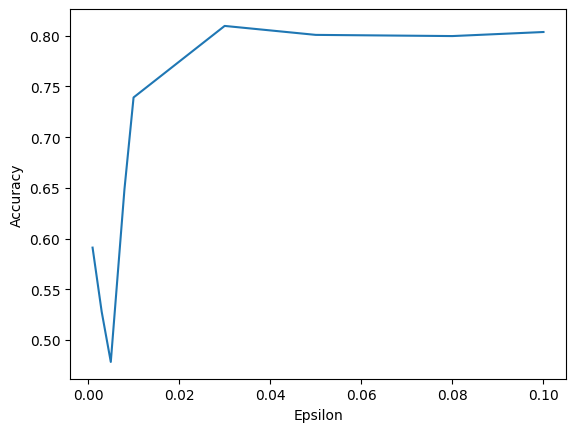

In [78]:
delta = 1e-5

epsilons = [0.001, 0.003, 0.005, 0.008, 0.01, 0.03, 0.05, 0.08, 0.1]
results  = [noisy_gradient_descent(10, epsilon, delta) for epsilon in epsilons]
thetas, biases = zip(*results)
accs     = [accuracy(theta, bias) for theta, bias in zip(thetas, biases)]

plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.plot(epsilons, accs);